In [36]:
import os

import pandas as pd
import numpy as np
import shap

from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.ensemble import RandomForestRegressor

# This function works only on command line
def double_heatmap(data1, data2, cbar_label1, cbar_label2,
                   title='', subplot_top=0.86, cmap1='viridis', cmap2='magma', 
                   center1=0.5, center2=0, grid_height_ratios=[1,4],
                   figsize=(14,10)):
    # do the actual plotting
    # here we plot 2 seperate heatmaps one for the predictions and actual percentiles
    # the other for the contributions
    # the reason I chose to do this is because of the difference in magnitudes
    # between the percentiles and the contributions
    fig, (ax,ax2) = plt.subplots(nrows=2, figsize=figsize, 
                                 gridspec_kw={'height_ratios':grid_height_ratios})

    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.02, top=subplot_top)

    # heatmap for actual and predicted percentiles
    sns.heatmap(data1, cmap="viridis", ax=ax, xticklabels=False, center=center1,
                cbar_kws={'location':'top', 
                          'use_gridspec':False, 
                          'pad':0.1,
                          'label': cbar_label1})
    ax.set_xlabel('')

    # heatmap of the feature contributions
    sns.heatmap(data2, ax=ax2, xticklabels=False, center=center2, cmap=cmap2,
                cbar_kws={'location':'bottom', 
                          'use_gridspec':False, 
                          'pad':0.07, 
                          'shrink':0.41,
                          'label': cbar_label2})
    ax2.set_ylabel('');
    return fig

In [3]:
workdir = "/Users/youngsun/repos/github/perftasks/ML/interpretability/tutorials/IMLwPython"

datapath = os.path.join(workdir, "combine_data_since_2000_PROCESSED_2018-04-26.csv")
data_df = pd.read_csv(datapath)

# onyl get players that have been in the league for 3 years
data_df2 = data_df.loc[data_df.Year <= 2015].copy()

# calculate the player AV percentiles by position
data_df2['AV_pctile'] = data_df2.groupby('Pos').AV.rank(pct=True, method='min', ascending=True)

# Get the data for the position we want, in this case it's DE
pos_df = data_df2.loc[data_df2.Pos=='DE'].copy().reset_index(drop=True)

In [32]:
# Combine measurables
features = ['Forty',
            'Wt',
            'Ht',
            'Vertical',
            'BenchReps',
            'BroadJump',
            'Cone',
            'Shuttle']
# what we want to predict
target = 'AV_pctile'

# Split the data into train and test sets
train_df = pos_df.loc[pos_df.Year <= 2011]
test_df = pos_df.loc[pos_df.Year.isin([2012, 2013, 2014, 2015])]

X = train_df[features].values
y = train_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

# best parameter set
pipe = Pipeline([("imputer", Imputer(strategy='median')), ("estimator",
    RandomForestRegressor( max_features=6, min_samples_split=63,
           n_estimators=500, random_state=420))])

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    #search.fit(X, y) 
    pipe.fit(X, y)

y_pred = pipe.predict(X_test)

estimator = pipe.named_steps['estimator']
imputer = pipe.named_steps['imputer']

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(estimator)

test_X_imp = imputer.transform(X_test)

# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(test_X_imp)

# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

test_X_imp = imputer.transform(X_test)

test_X_imp_df = pd.DataFrame(test_X_imp, columns=features)

# get the prediction and actual target values to plot
y_test_and_pred_df = pd.DataFrame(np.column_stack((y_test, y_pred)),
    index=test_df.Player,
    columns=['true_AV_pctile', 'pred_AV_pctile'])




(96, 2)


In [13]:
# plot the explanation for a single prediction
#shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])
#shap.force_plot(test_X_imp_df.iloc[0, :], test_shap_vals[0, :])

# visualize the first prediction's explanation
shap.force_plot(shap_explainer.expected_value, test_shap_vals[0,:], test_X_imp_df.iloc[0,:])

In [7]:
shap.force_plot(shap_explainer.expected_value, test_shap_vals[:,:], test_X_imp_df.iloc[:,:])

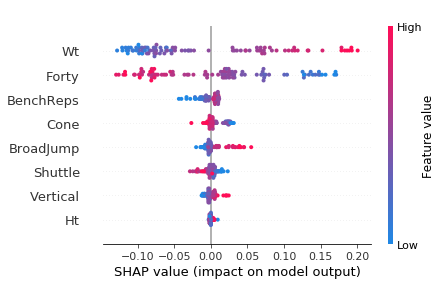

In [8]:
shap.summary_plot(test_shap_vals, test_X_imp_df, auto_size_plot=False)

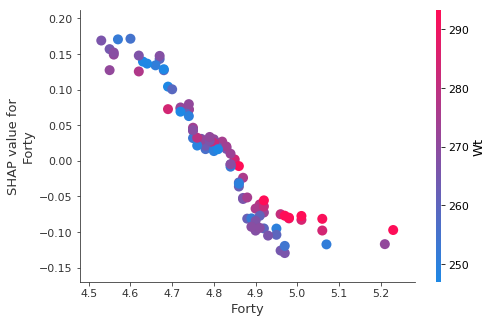

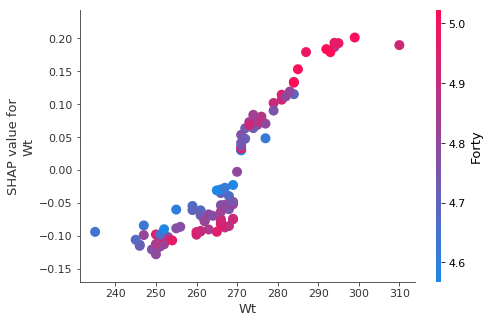

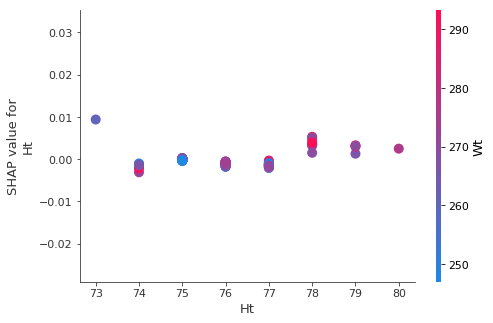

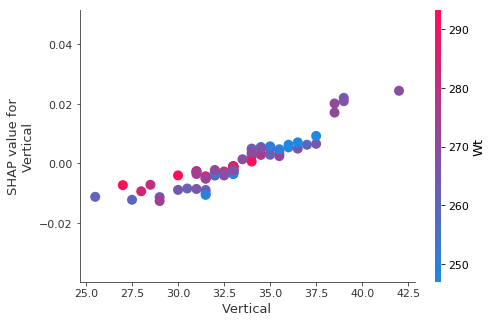

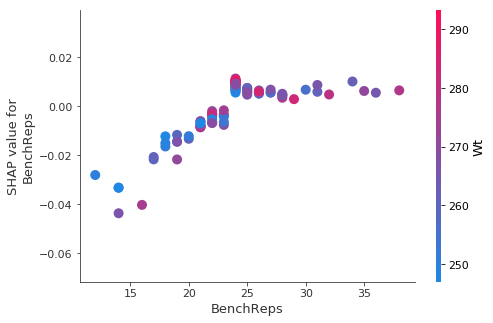

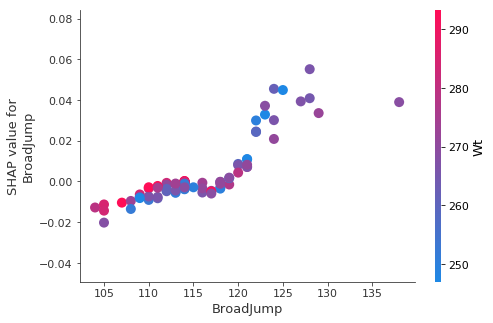

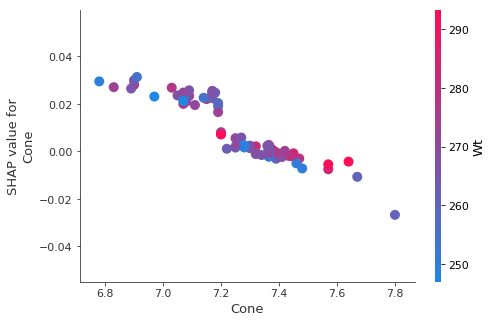

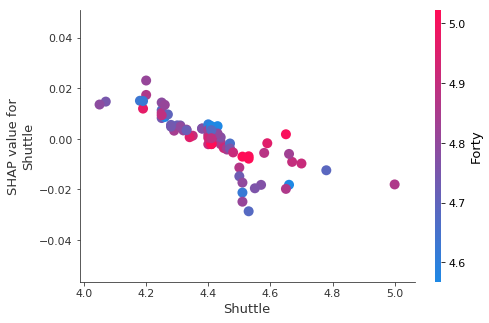

In [9]:
for feat in features:
    shap.dependence_plot(feat, test_shap_vals, test_X_imp_df, dot_size=100)

In [38]:

test_shap_df = pd.DataFrame(np.column_stack((test_shap_vals, y_test_and_pred_df)),
                            columns= features + ['true_AV_pctile', 
                                                 'pred_AV_pctile'])
test_shap_df.sort_values('pred_AV_pctile', inplace=True)


title = 'SHAP Values for each prediction in the testing data'
# NOTE: this plot work only in command line
#fig = double_heatmap(test_shap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
#                     test_shap_df[features].T, '%ile', 'SHAP Value',
#                     title=title, subplot_top=0.89)
#fig.axes[1].set_xlabel('Player');